The goal of this work is determine price of dwellings if we have other parameters like neoghbourhood, type of room, minimum nights, geographical coordinates and so on. We are going to make several models like Logistic Regression, LassoCV, ElasticCV, RodgeCV. We also are going to evaluate quality of the models using 4 metrics: MAE, MAPE, R2 and MSE

Techniques: 
1) Remove all records with zero price. Effect: MAPE metrics is number instead of infinity in case of appartments with zero price;
2) Changed price column to its logarythm. Effect: significantly improving of metrics, except of Logistic Regression;
3) We removed neighbourhood columns. Instead of this we separated them into three groups: cheep neighbourhoods, expensive neigbourhood and medium neighbourhooods. Effect: Logistic Regression now have good metrics that are similar to the metrics of the other models; 4) Distance to Manhattan instead of Geographical coordinates does not improve significantly the metrics


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df['last_review'].isna().sum(), df['reviews_per_month'].isna().sum()

(10052, 10052)

It seems that if we have NA in last_review column then we don't have last review, then we don't have reviews, then we have NA in reviews_per_month columns. Further we fill this column by 0

## EDA

In [4]:
df = df.drop(['name', 'id', 'host_id', 'host_name', 'last_review'], axis = 1)
df.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [5]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [7]:
df['reviews_per_month']=df['reviews_per_month'].fillna(0)
df['reviews_per_month'].isna().sum()

0

In [8]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


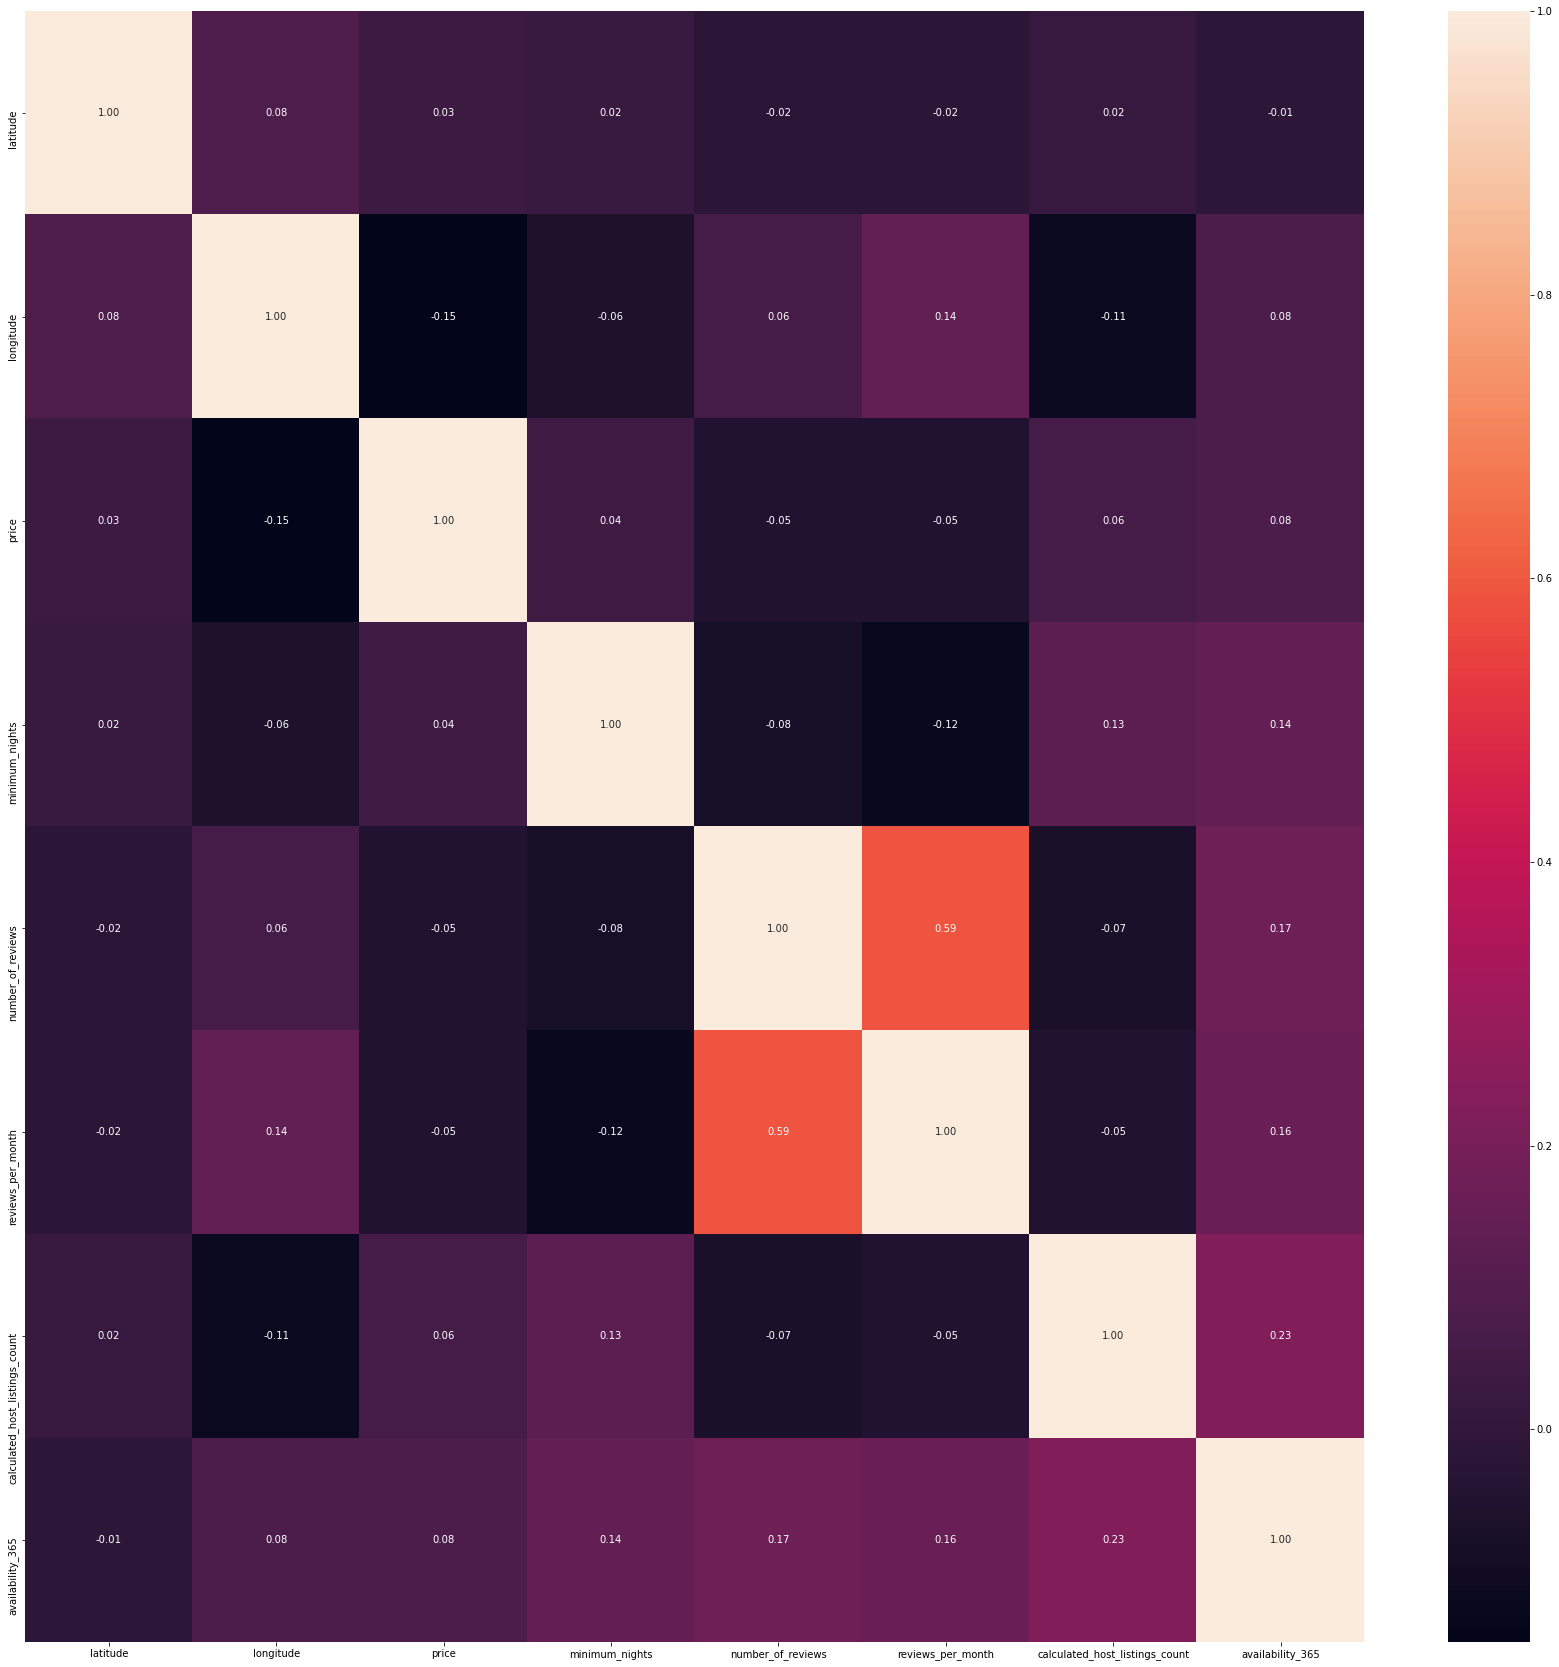

In [9]:
import matplotlib.pyplot as plt
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, fmt='.2f')

We have no high positive or negative correlation between factors

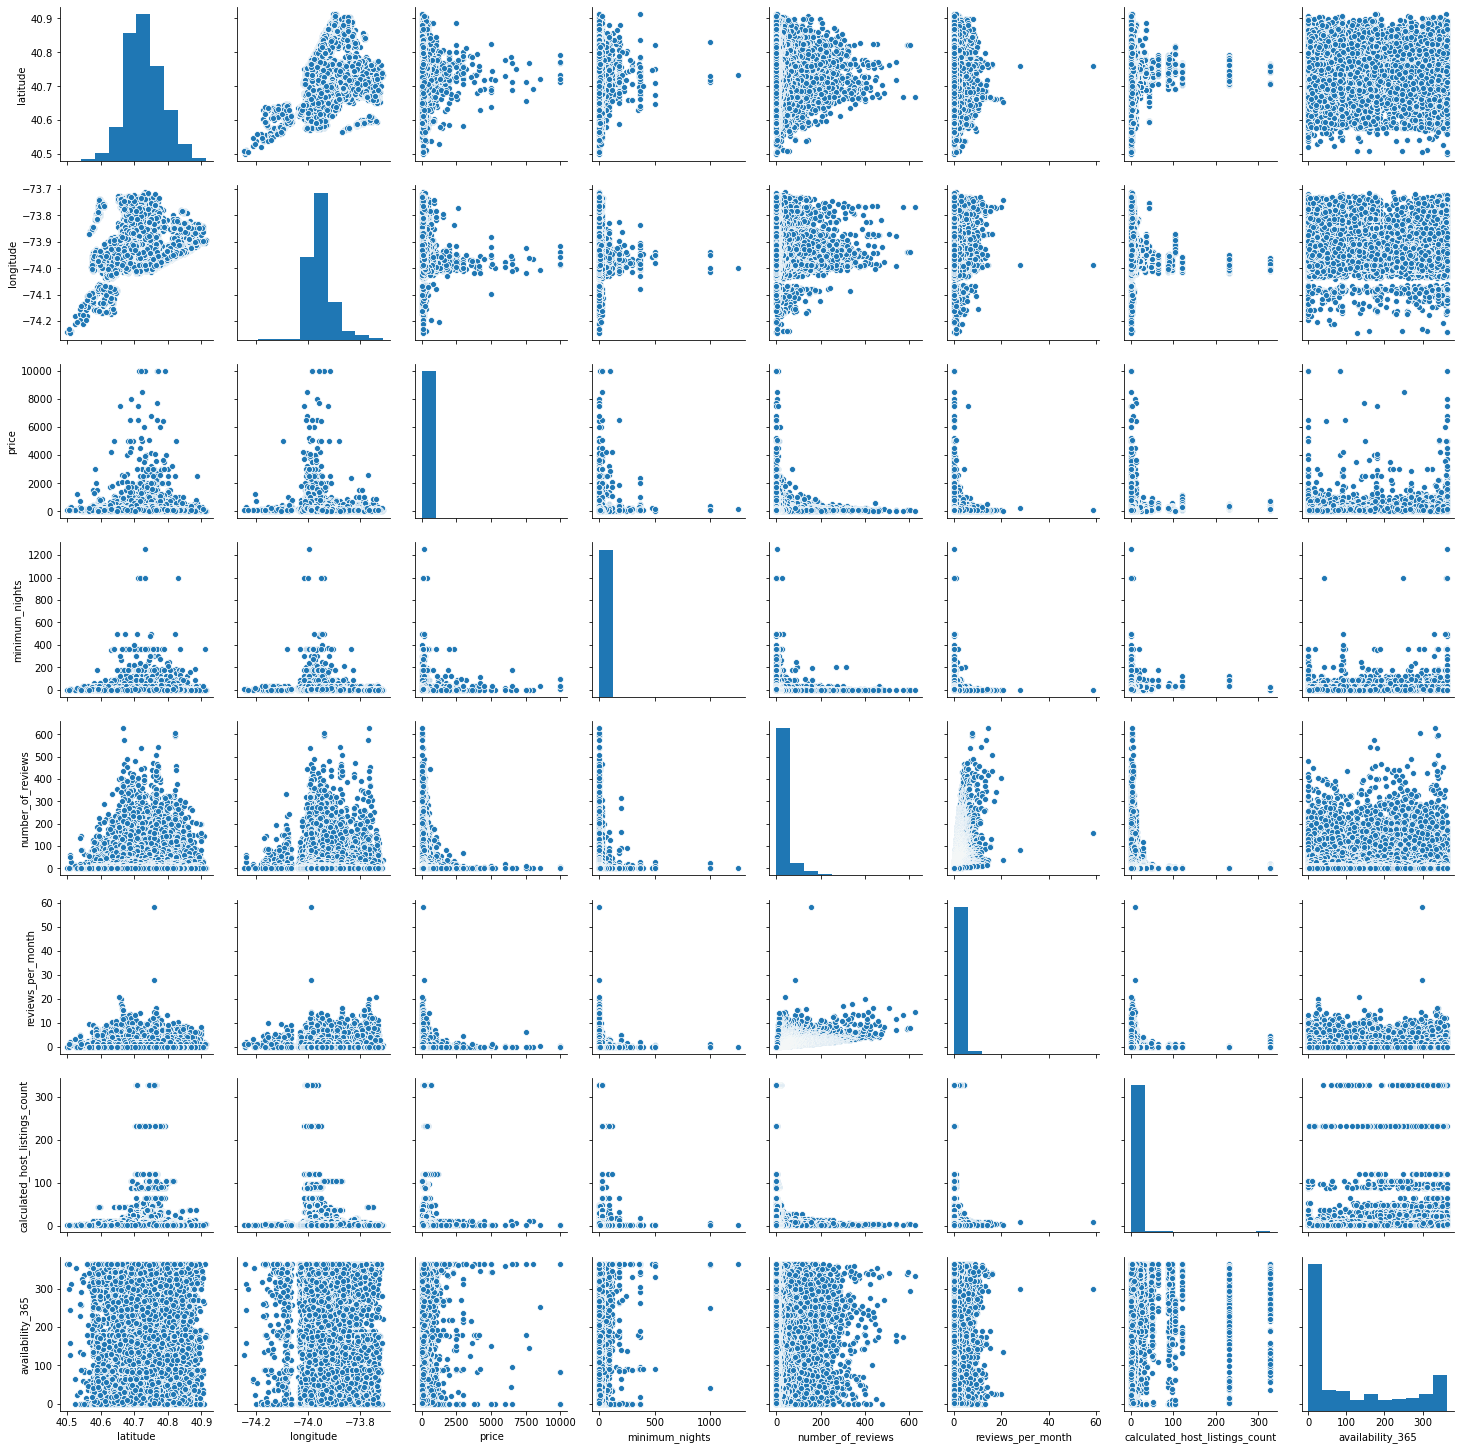

In [10]:
sns.pairplot(df)

In [11]:
data =  pd.get_dummies(df['neighbourhood_group'])
data

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,1,0,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,1,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
48890,0,1,0,0,0
48891,0,1,0,0,0
48892,0,0,1,0,0
48893,0,0,1,0,0


In [12]:
data = pd.concat([data, pd.get_dummies(df['neighbourhood']), df['longitude'], df['latitude'], df['price'], df['minimum_nights'], df['number_of_reviews'], df['reviews_per_month'], df['calculated_host_listings_count'], df['availability_365'],pd.get_dummies(df['room_type']) ], axis=1)
data

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Allerton,Arden Heights,Arrochar,Arverne,Astoria,...,latitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room
0,0,1,0,0,0,0,0,0,0,0,...,40.64749,149,1,9,0.21,6,365,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,40.75362,225,1,45,0.38,2,355,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,40.80902,150,3,0,0.00,1,365,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,40.68514,89,1,270,4.64,1,194,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,40.79851,80,10,9,0.10,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,0,1,0,0,0,0,0,0,0,0,...,40.67853,70,2,0,0.00,2,9,0,1,0
48891,0,1,0,0,0,0,0,0,0,0,...,40.70184,40,4,0,0.00,2,36,0,1,0
48892,0,0,1,0,0,0,0,0,0,0,...,40.81475,115,10,0,0.00,1,27,1,0,0
48893,0,0,1,0,0,0,0,0,0,0,...,40.75751,55,1,0,0.00,6,2,0,0,1


## Testing as is

Probably, we obtain a bad solution now, but we need start point. All further transformations we will compare with this primitive solution

In [13]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))* 100


def dataframe_metrics(y_test, y_pred):
    stats = [
        metrics.mean_absolute_error(y_test, y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        metrics.r2_score(y_test, y_pred),
        mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats
    
def do_tests (x_train, y_train, x_test, y_test):
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    lasso = LassoCV()
    lasso.fit(x_train, y_train)
    ridge = RidgeCV()
    ridge.fit(x_train, y_train)
    elastic = ElasticNetCV()
    elastic.fit(x_train, y_train)
    results = []
    results.append(dataframe_metrics(y_test, lr.predict(x_test)))
    results.append(dataframe_metrics(y_test, lasso.predict(x_test)))
    results.append(dataframe_metrics(y_test, ridge.predict(x_test)))
    results.append(dataframe_metrics(y_test, elastic.predict(x_test)))
    return results
    

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(['price'], axis=1), data['price'], test_size = 0.3 , random_state = 18)

In [16]:
result = do_tests(x_train, y_train, x_test, y_test)
result

<ipython-input-14-162fd01dffd7>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))* 100
<ipython-input-14-162fd01dffd7>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))* 100
<ipython-input-14-162fd01dffd7>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))* 100
<ipython-input-14-162fd01dffd7>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))* 100


[[101007823.83888063, 6347101499.447434, -516460248102111.3, inf],
 [75.65659405207609, 269.1839729256308, 0.07106695980832145, inf],
 [73.29126810671286, 266.8655242551389, 0.0869996235695788, inf],
 [88.1200432127273, 275.3935541798652, 0.027715069152360106, inf]]

## Remove appartments with 0 price

Because we have MAPE metric is equal to inf it makes sense to remove all appartments with price 0. These cases look strange, how can price be equal to 0?

In [17]:
part = df[df['price'] == 0]
part

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
23161,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,0.05,4,28
25433,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2.56,4,127
25634,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,0.71,5,0
25753,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,0.53,2,0
25778,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,0.15,1,73
25794,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,4.28,6,176
25795,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,4.37,6,232
25796,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,4.35,6,222
26259,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,0.00,1,0
26841,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,0.11,6,333


In [18]:
x_test['price'] = y_test
x_train['price'] = y_train
x_test

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Allerton,Arden Heights,Arrochar,Arverne,Astoria,...,latitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,price
6794,0,1,0,0,0,0,0,0,0,0,...,40.66003,3,73,1.34,1,120,1,0,0,150
14429,0,0,1,0,0,0,0,0,0,0,...,40.72152,2,4,0.10,2,1,0,1,0,65
46503,0,0,0,1,0,0,0,0,0,1,...,40.76411,3,0,0.00,1,43,0,1,0,55
48230,0,0,0,1,0,0,0,0,0,0,...,40.69658,1,2,2.00,1,359,0,1,0,50
33194,0,1,0,0,0,0,0,0,0,0,...,40.68716,30,0,0.00,3,196,1,0,0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28092,0,0,0,1,0,0,0,0,0,1,...,40.76354,1,6,0.31,1,0,0,1,0,50
43152,0,0,0,1,0,0,0,0,0,0,...,40.71668,1,13,4.15,1,359,1,0,0,250
35161,0,1,0,0,0,0,0,0,0,0,...,40.71615,2,3,0.48,2,330,1,0,0,150
31299,0,0,1,0,0,0,0,0,0,0,...,40.71313,3,48,3.19,2,181,0,1,0,89


In [19]:
indexes = x_test[x_test['price'] == 0].index.tolist()
x_test = x_test.drop(indexes)

In [20]:
indexes = x_train[x_train['price'] == 0].index.tolist()
x_train = x_train.drop(indexes)

In [21]:
y_test = x_test['price']
y_train = x_train['price']
x_test.drop(['price'], axis=1, inplace=True)
x_train.drop(['price'], axis=1, inplace=True)

We have only 11 cases with 0 price, so we can remove them. Moreover, total number of records is 48895

In [22]:
result = do_tests(x_train, y_train, x_test, y_test)
result

[[14340429.113369161,
  897077654.6848688,
  -10315372101017.547,
  19189128.437501457],
 [75.65588107364583, 269.2047176304118, 0.07105467507674945, 55.1398700121008],
 [73.28830748723333,
  266.88574788619087,
  0.08698989224181874,
  49.63330803889106],
 [88.12645224039628,
  275.4159398973106,
  0.027694003347375484,
  79.96421890882604]]

SUMMARY: MAPE metric is number now

## Price

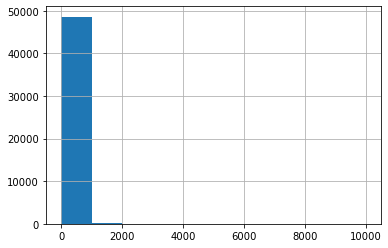

In [23]:
data['price'].hist()

In [24]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [25]:
result = do_tests(x_train, y_train, x_test, y_test)
result

[[83338.5674815356, 5213319.768522178, -55163761699524.92, 1906963.5454302325],
 [0.36855030752590634,
  0.5100260915083621,
  0.47202916405595186,
  7.787173262319171],
 [0.3422526714591876,
  0.477744552028504,
  0.5367487154414701,
  7.1753554147656144],
 [0.3698228393055362,
  0.5114581253352443,
  0.4690601648381466,
  7.820944419066583]]

## Neighbourhoods 

In [26]:
df['neighbourhood'].unique(), df['neighbourhood'].isna().sum()

(array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
        'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
        'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
        'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
        'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
        'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
        'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
        'SoHo', 'Upper East Side', 'Prospect Heights',
        'Washington Heights', 'Woodside', 'Brooklyn Heights',
        'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
        'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
        'Highbridge', 'Financial District', 'Ridgewood',
        'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
        'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
        'Greenwich Village', 'Little Italy', 'East Flatbush',
        'Tompk

In [27]:
expensive_neighbourhoods = []
cheep_neighbourhoods = [] 
for i in range(0, len(df['neighbourhood'].value_counts().index)):
    size_classes = df
    size_classes['class'] = df['neighbourhood'] == df['neighbourhood'].value_counts().index[i]
    in_neigbourhood = size_classes[size_classes['class'] == True]
    out_neigbourhood = size_classes[size_classes['class'] == False]
    in_heighourhood = in_neigbourhood.drop(['class'], axis=1)
    out_heighourhood = out_neigbourhood.drop(['class'], axis=1)
    if (in_heighourhood.describe()['price']['25%'] > out_heighourhood.describe()['price']['50%']):
        expensive_neighbourhoods.append(df['neighbourhood'].value_counts().index[i])
    if (in_heighourhood.describe()['price']['75%'] < out_heighourhood.describe()['price']['50%']):
        cheep_neighbourhoods.append(df['neighbourhood'].value_counts().index[i])

In [28]:
x_train['is_cheep_neighbourhood'] = df.loc[x_train.index]['neighbourhood'].isin(set(cheep_neighbourhoods))
x_train['is_expensive_neighbourhood'] = df.loc[x_train.index]['neighbourhood'].isin(set(expensive_neighbourhoods))
x_train

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Allerton,Arden Heights,Arrochar,Arverne,Astoria,...,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood
24058,0,1,0,0,0,0,0,0,0,0,...,4,11,0.44,1,2,1,0,0,False,False
28074,0,1,0,0,0,0,0,0,0,0,...,3,37,1.90,1,82,1,0,0,False,False
48437,0,1,0,0,0,0,0,0,0,0,...,2,0,0.00,7,169,0,1,0,False,False
18512,0,1,0,0,0,0,0,0,0,0,...,5,37,1.16,2,72,0,1,0,False,False
5394,0,1,0,0,0,0,0,0,0,0,...,3,4,0.07,1,0,0,1,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,0,0,1,0,0,0,0,0,0,0,...,1,10,0.17,1,297,1,0,0,False,False
1726,0,0,1,0,0,0,0,0,0,0,...,2,68,0.92,1,63,1,0,0,False,True
35653,1,0,0,0,0,0,0,0,0,0,...,1,26,2.65,2,123,0,1,0,True,False
25720,0,0,1,0,0,0,0,0,0,0,...,2,2,0.09,1,0,1,0,0,False,False


In [29]:
x_test['is_cheep_neighbourhood'] = df.loc[x_test.index]['neighbourhood'].isin(set(cheep_neighbourhoods))
x_test['is_expensive_neighbourhood'] = df.loc[x_test.index]['neighbourhood'].isin(set(expensive_neighbourhoods))
x_test

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Allerton,Arden Heights,Arrochar,Arverne,Astoria,...,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood
6794,0,1,0,0,0,0,0,0,0,0,...,3,73,1.34,1,120,1,0,0,False,False
14429,0,0,1,0,0,0,0,0,0,0,...,2,4,0.10,2,1,0,1,0,False,False
46503,0,0,0,1,0,0,0,0,0,1,...,3,0,0.00,1,43,0,1,0,False,False
48230,0,0,0,1,0,0,0,0,0,0,...,1,2,2.00,1,359,0,1,0,True,False
33194,0,1,0,0,0,0,0,0,0,0,...,30,0,0.00,3,196,1,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28092,0,0,0,1,0,0,0,0,0,1,...,1,6,0.31,1,0,0,1,0,False,False
43152,0,0,0,1,0,0,0,0,0,0,...,1,13,4.15,1,359,1,0,0,False,False
35161,0,1,0,0,0,0,0,0,0,0,...,2,3,0.48,2,330,1,0,0,False,False
31299,0,0,1,0,0,0,0,0,0,0,...,3,48,3.19,2,181,0,1,0,False,False


In [30]:
x_test = x_test.drop(x_test.columns[5:226], axis=1)
x_test["is_cheep_neighbourhood"] = x_test["is_cheep_neighbourhood"].astype(int)
x_test["is_expensive_neighbourhood"] = x_test["is_expensive_neighbourhood"].astype(int)
x_test

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,longitude,latitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood
6794,0,1,0,0,0,-73.98567,40.66003,3,73,1.34,1,120,1,0,0,0,0
14429,0,0,1,0,0,-73.97999,40.72152,2,4,0.10,2,1,0,1,0,0,0
46503,0,0,0,1,0,-73.92076,40.76411,3,0,0.00,1,43,0,1,0,0,0
48230,0,0,0,1,0,-73.85615,40.69658,1,2,2.00,1,359,0,1,0,1,0
33194,0,1,0,0,0,-73.94601,40.68716,30,0,0.00,3,196,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28092,0,0,0,1,0,-73.91341,40.76354,1,6,0.31,1,0,0,1,0,0,0
43152,0,0,0,1,0,-73.80588,40.71668,1,13,4.15,1,359,1,0,0,0,0
35161,0,1,0,0,0,-73.94171,40.71615,2,3,0.48,2,330,1,0,0,0,0
31299,0,0,1,0,0,-73.98665,40.71313,3,48,3.19,2,181,0,1,0,0,0


In [31]:
x_train["is_cheep_neighbourhood"] = x_train["is_cheep_neighbourhood"].astype(int)
x_train["is_expensive_neighbourhood"] = x_train["is_expensive_neighbourhood"].astype(int)
x_train = x_train.drop(x_train.columns[5:226], axis=1)
x_train

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,longitude,latitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood
24058,0,1,0,0,0,-73.99207,40.68254,4,11,0.44,1,2,1,0,0,0,0
28074,0,1,0,0,0,-73.97771,40.65028,3,37,1.90,1,82,1,0,0,0,0
48437,0,1,0,0,0,-73.94372,40.69685,2,0,0.00,7,169,0,1,0,0,0
18512,0,1,0,0,0,-73.95644,40.68465,5,37,1.16,2,72,0,1,0,0,0
5394,0,1,0,0,0,-73.98558,40.67053,3,4,0.07,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,0,0,1,0,0,-73.94620,40.82654,1,10,0.17,1,297,1,0,0,0,0
1726,0,0,1,0,0,-74.00539,40.73364,2,68,0.92,1,63,1,0,0,0,1
35653,1,0,0,0,0,-73.84967,40.84184,1,26,2.65,2,123,0,1,0,1,0
25720,0,0,1,0,0,-73.98315,40.72547,2,2,0.09,1,0,1,0,0,0,0


In [32]:
result = do_tests(x_train, y_train, x_test, y_test)
result

[[0.355051229454812,
  0.49139230443028487,
  0.5099032220148757,
  7.463228282851844],
 [0.3607623077404159,
  0.4993811520946152,
  0.4938381140472262,
  7.615410430846481],
 [0.3550517001337746,
  0.4913944407027546,
  0.5098989607249829,
  7.463227845506647],
 [0.3612416924210973,
  0.500162958133535,
  0.49225203024150066,
  7.631292576980975]]

## Geographical Coordinates

In [33]:
df[df['neighbourhood_group'] == 'Manhattan'].describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,21661.000000,21661.000000,21661.000000,21661.000000,21661.000000,21661.000000,21661.000000,21661.000000
mean,40.765062,-73.974607,196.875814,8.579151,20.985596,0.976782,12.791330,111.979410
std,0.038463,0.022138,291.383183,24.050857,42.572277,1.524518,48.234766,132.677836
min,40.702340,-74.018510,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.731820,-73.991690,95.000000,1.000000,1.000000,0.020000,1.000000,0.000000
50%,40.760880,-73.980420,150.000000,3.000000,4.000000,0.280000,1.000000,36.000000
75%,40.795090,-73.953840,220.000000,6.000000,19.000000,1.300000,2.000000,230.000000
max,40.876650,-73.908550,10000.000000,1250.000000,607.000000,58.500000,327.000000,365.000000


In [34]:
manhattan_mean_longitude = df[df['neighbourhood_group'] == 'Manhattan'].describe()['longitude']['mean']
manhattan_mean_longitude

-73.97460674299501

In [35]:
manhattan_mean_latitude = df[df['neighbourhood_group'] == 'Manhattan'].describe()['latitude']['mean']
manhattan_mean_latitude

40.76506240709098

In [36]:
candidate_train = x_train.copy()
candidate_test = x_test.copy()


In [37]:
candidate_train['from_manhattan'] = np.sqrt((x_train['longitude'] - manhattan_mean_longitude)*(x_train['longitude'] - manhattan_mean_longitude) + (x_train['latitude'] - manhattan_mean_latitude) * (x_train['latitude'] - manhattan_mean_latitude))
candidate_train = candidate_train.drop(['longitude','latitude'], axis=1)
candidate_train

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood,from_manhattan
24058,0,1,0,0,0,4,11,0.44,1,2,1,0,0,0,0,0.084350
28074,0,1,0,0,0,3,37,1.90,1,82,1,0,0,0,0,0.114824
48437,0,1,0,0,0,2,0,0.00,7,169,0,1,0,0,0,0.074879
18512,0,1,0,0,0,5,37,1.16,2,72,0,1,0,0,0,0.082439
5394,0,1,0,0,0,3,4,0.07,1,0,0,1,0,0,0,0.095167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,0,0,1,0,0,1,10,0.17,1,297,1,0,0,0,0,0.067723
1726,0,0,1,0,0,2,68,0.92,1,63,1,0,0,0,1,0.043988
35653,1,0,0,0,0,1,26,2.65,2,123,0,1,0,1,0,0.146642
25720,0,0,1,0,0,2,2,0.09,1,0,1,0,0,0,0,0.040504


In [38]:
candidate_test['from_manhattan'] = np.sqrt((x_test['longitude'] - manhattan_mean_longitude)*(x_test['longitude'] - manhattan_mean_longitude) + (x_test['latitude'] - manhattan_mean_latitude) * (x_test['latitude'] - manhattan_mean_latitude))
candidate_test = candidate_test.drop(['longitude','latitude'], axis=1)
candidate_test

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,is_cheep_neighbourhood,is_expensive_neighbourhood,from_manhattan
6794,0,1,0,0,0,3,73,1.34,1,120,1,0,0,0,0,0.105613
14429,0,0,1,0,0,2,4,0.10,2,1,0,1,0,0,0,0.043874
46503,0,0,0,1,0,3,0,0.00,1,43,0,1,0,0,0,0.053855
48230,0,0,0,1,0,1,2,2.00,1,359,0,1,0,1,0,0.136828
33194,0,1,0,0,0,30,0,0.00,3,196,1,0,0,0,0,0.082985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28092,0,0,0,1,0,1,6,0.31,1,0,0,1,0,0,0,0.061216
43152,0,0,0,1,0,1,13,4.15,1,359,1,0,0,0,0,0.175527
35161,0,1,0,0,0,2,3,0.48,2,330,1,0,0,0,0,0.058946
31299,0,0,1,0,0,3,48,3.19,2,181,0,1,0,0,0,0.053311


In [39]:
result = do_tests(candidate_train, y_train, candidate_test, y_test)
result

[[0.35452548174331333,
  0.49134951119725856,
  0.5099885791204726,
  7.446353960737137],
 [0.3607623077404159,
  0.4993811520946152,
  0.4938381140472262,
  7.615410430846481],
 [0.3545275225711035, 0.4913507784200276, 0.5099860515737213, 7.4464059160454],
 [0.3612416924210973,
  0.500162958133535,
  0.49225203024150066,
  7.631292576980975]]

In [40]:
x_test = candidate_test
x_train = candidate_train

## Minimum Nights

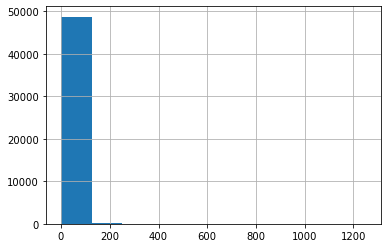

In [62]:
data['minimum_nights'].hist()

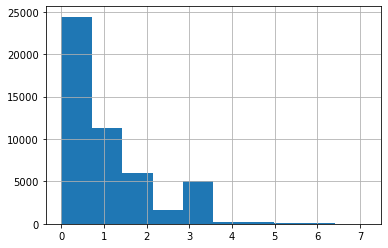

In [63]:
np.log(data['minimum_nights']).hist()

In [46]:
x_train['minimum_nights'] = np.log(x_train['minimum_nights'])
x_test['minimum_nights'] = np.log(x_test['minimum_nights'])

In [64]:
result = do_tests(x_train, y_train, x_test, y_test)
result

[[0.35452548174331333,
  0.49134951119725856,
  0.5099885791204726,
  7.446353960737137],
 [0.3607623077404159,
  0.4993811520946152,
  0.4938381140472262,
  7.615410430846481],
 [0.3545275225711035, 0.4913507784200276, 0.5099860515737213, 7.4464059160454],
 [0.3612416924210973,
  0.500162958133535,
  0.49225203024150066,
  7.631292576980975]]